In [89]:
import requests
import datetime
import pytz
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import plotly.graph_objects as go

plt.style.use('seaborn-v0_8-darkgrid')

user_name  = "WalvinDesu"
time_control = "Bullet"
#The method of loading data, options are API, FILE or BOTH
data_source = "BOTH"
#If loading using only the API, the following variables control how far to go back
year, month, day = 2023, 4, 10
#If using the FILE or BOTH options for data_source, store the file in the data folder and add its name below
file_name = "lichess_WalvinDesu_2023-04-07.pgn"


## Importing Lichess data into Pandas

In [90]:
def API_Load(user_name, year, month, day, hour=0, minute=0, second=0):
    """
    Imports chess data via the Lichess API and returns a list of games
    """
    start_date = datetime.datetime(year, month, day, hour, minute, second, tzinfo=pytz.UTC).timestamp()
    start_date = str(int(start_date*1000))
    x = requests.get(f"http://lichess.org/api/games/user/{user_name}?since={start_date}")
    #x = requests.get(f"http://lichess.org/api/games/user/{user_name}")
    chess_data = x.content.decode("utf-8")
    #Read the data as a list, dropping the final empty row    
    chess_data = chess_data.split("\n\n\n")[:-1]
    return chess_data

def File_Load(file_name):
    """
    Imports chess data via a saved file in the data folder and returns a list of games
    """
    chess_data = open("../data/" + file_name).read()
    #Read the data as a list, dropping the final empty row    
    chess_data = chess_data.split("\n\n\n")[:-1]
    return chess_data

def Up_To_Date_File_Load(user_name, file_name):
    """
    Imports chess data via a saved file in the data folder, updating it via the Lichess API
    and returning a list of games
    """
    chess_data = File_Load(file_name)
    last_game = line2dict(chess_data[0])
    last_dt = [int(_) for _ in (last_game["UTCDate"].replace(".",":") + ":" + last_game["UTCTime"]).split(":")]
    api_data = API_Load(user_name, year = last_dt[0], month = last_dt[1], day = last_dt[2], hour= last_dt[3], minute= last_dt[4], second = last_dt[5])
    return api_data[1:] + chess_data
  

def line2dict(line):
    """
    Parses each element of the list of imported data into a Dictionary
    """
    data, game  = line.split("\n\n")
    data = data.replace("[","").replace("]","").replace('"', "")
    datadict = {x[0]:x[1] for l in data.split("\n")[:-1] for x in [l.split(" ",1)]}
    datadict["PGN"] = game
    return datadict

if data_source.upper() == "API":
    chess_data = API_Load(user_name, year, month, day)
elif data_source.upper() == "FILE":
    chess_data = File_Load(file_name)
elif data_source.upper() == "BOTH":
    chess_data = Up_To_Date_File_Load(user_name, file_name)



## Modify the DataFrame to the perspective of the User

In [91]:
df = pd.DataFrame([line2dict(i) for i in chess_data])
#Process DataFrame
df = df[df["Event"].str.contains(time_control)]

df = df.set_index(pd.to_datetime(df["UTCDate"] + df["UTCTime"], format = "%Y.%m.%d%H:%M:%S"))
df = df.drop(["Date", "UTCDate", "UTCTime"], axis = 1)

df["UserColour"]     = np.where(df["White"] == user_name, "White", "Black")
df["OppName"]        = np.where(df["White"] == user_name, df["Black"], df["White"])
df["UserElo"]        = np.where(df["White"] == user_name, df["WhiteElo"], df["BlackElo"])
df["OppElo"]         = np.where(df["White"] == user_name, df["BlackElo"], df["WhiteElo"])
df["UserRatingDiff"] = np.where(df["White"] == user_name, df["WhiteRatingDiff"], df["BlackRatingDiff"])
df["OppRatingDiff"]  = np.where(df["White"] == user_name, df["BlackRatingDiff"], df["WhiteRatingDiff"])
df["WDL"]            = np.where(df["Result"] == "1/2-1/2", "D", 
                             np.where(((df["White"] == user_name) & (df["Result"] == "1-0")) | ((df["Black"] == user_name) & (df["Result"] == "0-1")), "W", "L"))
df = df.drop(["White", "Black", "WhiteElo", "BlackElo", "WhiteRatingDiff", "BlackRatingDiff", "Result", "FEN"], axis = 1)
#Convert ELO to float, removing provisional ELO ratings
df = df[(df["UserElo"].str[-1] != "?") & (df["OppElo"].str[-1] != "?")]
df["UserElo"] = df["UserElo"].astype(float)
df["OppElo"] = df["OppElo"].astype(float)

df.head()


,Event,Site,Variant,TimeControl,ECO,PGN,Termination,UserColour,OppName,UserElo,OppElo,UserRatingDiff,OppRatingDiff,WDL
2023-04-13 00:54:44,Rated Bullet game,https://lichess.org/erJy4PTi,Standard,120+1,D02,1. d4 d5 2. Nf3 Bg4 3. Bf4 Bxf3 4. exf3 Nc6 5....,NaN,White,fox-son-of-LION,1489.0,1497.0,+6,-6,W
2023-04-13 00:49:25,Rated Bullet game,https://lichess.org/vzi4ptPI,Standard,120+1,D10,1. d4 d5 2. c4 c6 3. Nc3 Nf6 4. e3 Bf5 5. Nf3 ...,NaN,Black,alejoiv,1483.0,1464.0,+6,-6,W
2023-04-13 00:44:30,Rated Bullet game,https://lichess.org/WJwzwFHx,Standard,120+1,C45,1. e4 e5 2. d4 exd4 3. Nf3 Nc6 4. Nxd4 Nxd4 5....,NaN,Black,karamella69,1478.0,1472.0,+5,-5,W
2023-04-13 00:37:41,Rated Bullet game,https://lichess.org/qBuVC9mR,Standard,120+1,C20,1. e4 e5 2. d3 Nc6 3. Nc3 Bc5 4. Qe2 d6 5. Be3...,NaN,Black,KuroiKenshiGuts,1478.0,1464.0,+0,+1,D
2023-04-13 00:32:44,Rated Bullet game,https://lichess.org/fs4J6Q5l,Standard,120+1,A80,1. d4 f5 2. Nf3 e6 3. Bf4 Nf6 4. e3 b6 5. c3 B...,NaN,White,German_Lopez_Mejia,1472.0,1482.0,+6,-6,W


In [92]:

#A seperate DataFrame for Daily analysis (potentially could set to become monthly etc)
daily_user_data = pd.DataFrame()
daily_user_data["NumGames"]  = df["UserElo"].resample("D", offset="6H").count()
daily_user_data["WinCount"]  = df[df["WDL"]=="W"]["UserElo"].resample("D", offset="6H").count()
daily_user_data["LossCount"] = df[df["WDL"]=="L"]["UserElo"].resample("D", offset="6H").count()
daily_user_data["DrawCount"] = df[df["WDL"]=="D"]["UserElo"].resample("D", offset="6H").count()
daily_user_data[["NumGames","WinCount","LossCount","DrawCount"]] = daily_user_data[["NumGames","WinCount","LossCount","DrawCount"]].fillna(0).astype(int)
daily_user_data["NetWins"] = daily_user_data["WinCount"] - daily_user_data["LossCount"]
daily_user_data['CurrentStreak'] = daily_user_data.groupby((daily_user_data['NumGames'] == 0).cumsum()).cumcount()
daily_user_data.tail()


,NumGames,WinCount,LossCount,DrawCount,NetWins,CurrentStreak
2023-04-08 06:00:00,28,15,11,2,4,98
2023-04-09 06:00:00,29,8,20,1,-12,99
2023-04-10 06:00:00,34,15,19,0,-4,100
2023-04-11 06:00:00,88,43,41,4,2,101
2023-04-12 06:00:00,22,13,5,4,8,102


## Analysis of User Activity

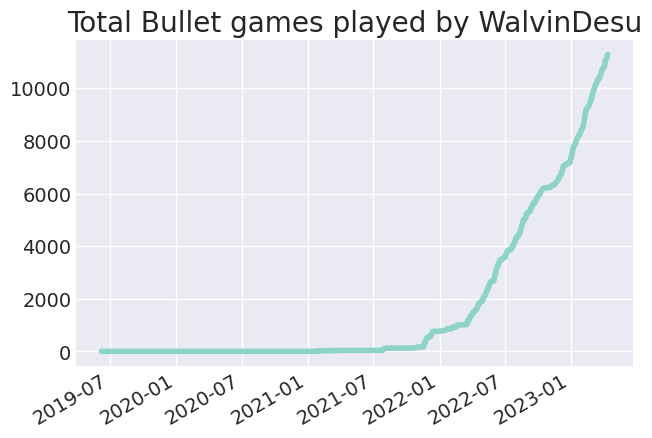

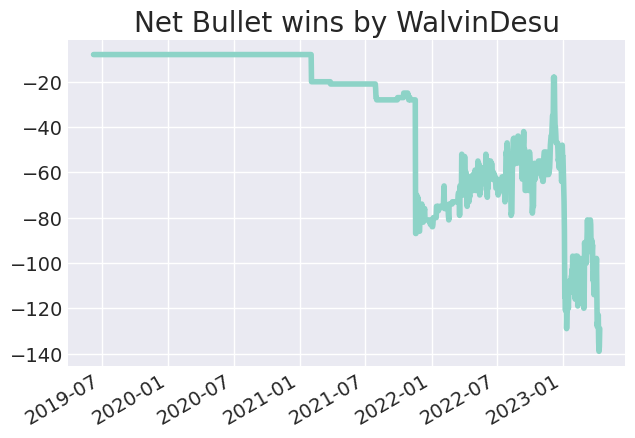

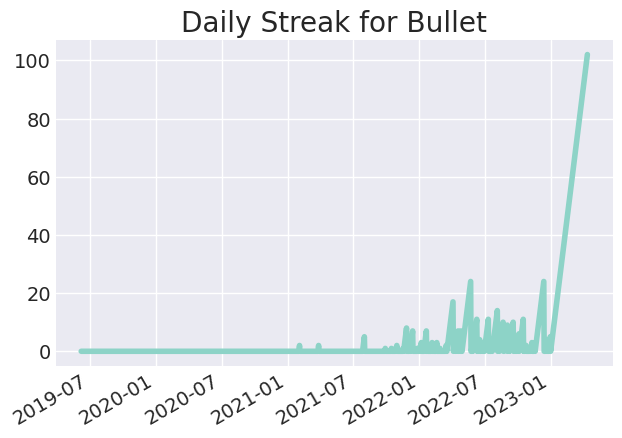

NumGames         29.446475
WinCount         14.211488
LossCount        14.548303
DrawCount         0.686684
NetWins          -0.336815
CurrentStreak    17.801567
dtype: float64

In [102]:


# type(monthly_num_games)
# plt.bar(monthly_num_games.index.tolist(), monthly_num_games.values)
# plt.xlabel('Month')
# plt.ylabel('Number of games')
# plt.show()

# daily_user_data[daily_user_data["NumGames"] != 0][["WinCount", "DrawCount", "LossCount"]].plot(kind="bar", stacked=True, figsize=(10,6))
# plt.xlabel('Date')
# plt.ylabel('Number of Games')
# plt.title('Number of Games by Result')
# plt.show()

daily_user_data_non_zero = daily_user_data[daily_user_data["NumGames"] != 0]
#Cumulative Number of Games plot
daily_user_data["NumGames"].cumsum().plot(kind="line", title="Total " + time_control+ " games played by " + user_name)
plt.show()
#Net Number of Wins plot
daily_user_data["NetWins"].cumsum().plot(kind="line", title="Net " + time_control+ " wins by " + user_name)
plt.show()
#Current Streak plot
daily_user_data['CurrentStreak'] = daily_user_data.groupby((daily_user_data['NumGames'] == 0).cumsum()).cumcount()
daily_user_data['CurrentStreak'].plot(kind='line', title= "Daily Streak for "+ time_control)
plt.show()

#---------------------------------------------------------------------------------------------------------------------
mean_daily =  daily_user_data_non_zero.mean()
mean_daily


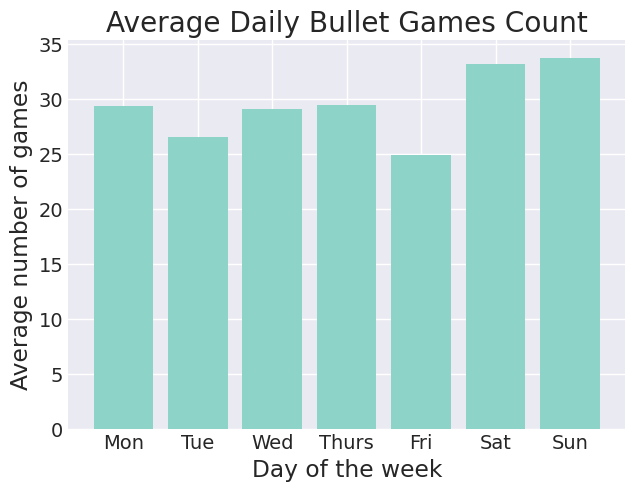

In [101]:
day_names = ['Mon', 'Tue', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']

plt.bar(day_names, daily_user_data_non_zero["NumGames"].groupby(daily_user_data_non_zero.index.dayofweek).mean()) # create bar chart
plt.title("Average Daily " + time_control + " Games Count")
plt.xlabel("Day of the week")
plt.ylabel("Average number of games")
plt.show()


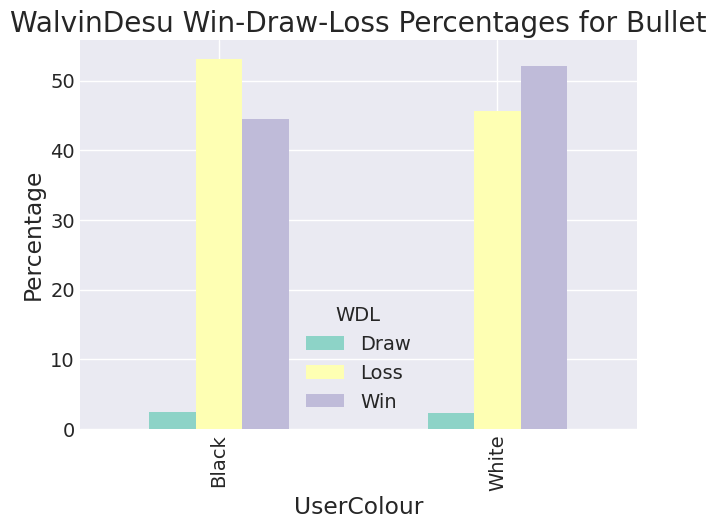

In [95]:
#Grouped bar chart for wins losses draws as white and black
wdl_pivot = pd.pivot_table(df, index="UserColour", columns="WDL", aggfunc="size")
wdl_pivot = wdl_pivot.div(wdl_pivot.sum(axis=1), axis =0)*100


fig, ax = plt.subplots()
wdl_pivot.plot(kind="bar", ax=ax)   #try a pie chart.
ax.set_ylabel("Percentage")
ax.set_title(user_name +" Win-Draw-Loss Percentages for " + time_control)
ax.legend(title="WDL", labels = ["Draw","Loss", "Win"])
plt.show()



In [96]:
#Create daily statistics Dataframe
daily_elo_ohlc = df["UserElo"].resample("D", offset="6H").ohlc()
#Forward fill missing values using the close value of the last non-missing day
daily_elo_ohlc['close'].ffill(inplace=True)
daily_elo_ohlc.fillna({'high': daily_elo_ohlc['close'], 
                        'low': daily_elo_ohlc['close'], 
                        'open': daily_elo_ohlc['close']}, inplace=True)


fig = go.Figure(data =[go.Candlestick(x=daily_elo_ohlc.index,
                open =daily_elo_ohlc['open'],
                high =daily_elo_ohlc['high'],
                low  =daily_elo_ohlc['low'],
                close=daily_elo_ohlc['close'])])
fig.update_layout(
    title = user_name + " Daily ELO performance",
    yaxis_title = "ELO"
)

fig.show()

In [97]:
(user_elo_ohlc["close"].pct_change() * 100).mean()


NameError: name 'user_elo_ohlc' is not defined

In [ ]:
#Mald index - number of resignations, number of losses, time to resign etc see if it predicts future losses
#see if time of day predicts losses/wins
#openings frequency? tree where each leaf gives W/L rate
#number of losses per day #number of games per day
#get btc data
#win more as black?
#how much elo have you gained vs taken from opponents

#Literate=True in lichess API gives you notes in the PGN, evals gives you the engine rating throughout the game! accuracy=true gives, opening=, 
#get performance statistics of a user, ratings history etc is possible with the API

#longest break period
#An analysis of days off -temperature plot?
#Cumulative wins and loses daily graph
#A point and figure chart
#How would you show a user plateauing? Playing a lot but gaining less elo
#Indicators/wyckoff 
#games played on holidays/current events

#Api gets blunders ==> Largest blunders of each week?